In [70]:
# Librarys and Modules 

import pandas as pd 
import os
import copy
import statsmodels.api as sm
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.metrics import r2_score
import optuna
import seaborn as sns
import pandas_ta as ta
import matplotlib.pyplot as plt
import yfinance as yf


In [71]:
#Reading file into pandas data frame 

# Define the path to the folder containing the CSV files
folder_path = r"./Contract Pricing"

# List all files in the directory as List 
file_names = [
    'Contracts Pricing - July 24.csv',
    'Contracts Pricing - September 24.csv',
    'Contracts Pricing - December 24.csv',
    'Contracts Pricing - March 25.csv',
    'Contracts Pricing - May 25.csv',
    'Contracts Pricing - July 25.csv',
    'Contracts Pricing - September 25.csv',
    'Contracts Pricing - December 25.csv',
    'Contracts Pricing - March 26.csv',
    'Contracts Pricing - May 26.csv',
]

# Create an empty dictionary to store DataFrames
dataframes = {}

# Loop through each file and read it into a DataFrame
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name) 
    df_name = file_name.split('.')[0]  # Use the file name without extension as the DataFrame name
    dataframes[df_name] = pd.read_csv(file_path) 
    


In [72]:
# Cleaning Contarcts Pricing Data 
import pandas as pd
import numpy as np

#Adding Data Frames to list 
dfs_list = list(dataframes.values())

for df in dfs_list:
    # Convert the 'Date' column to datetime with the correct format
    df['Date'] = pd.to_datetime(df['Date'], format="%b %d, %Y")
    df['Maturity Date'] = pd.to_datetime(df['Maturity Date'], format="%m/%d/%Y")

    
    # Replace '-' with NaN in 'Adj Close' column
    df['Adj Close'].replace('-', np.nan, inplace=True)
    
    # Replace '-' with 0 in 'Volume' column
    df['Volume'].replace('-', 0, inplace=True)
    
    # Drop rows with NaN values in 'Adj Close' column
    df.dropna(subset=['Adj Close'], inplace=True)
    nan_values = df.isna().sum()
    
    #Finding time to maturity
    df['Time to Maturity'] = (df['Maturity Date'] - df['Date']).dt.days # Subtracts Calander dates 
    
     # Convert columns to to numeric type
    df['Adj Close'] = pd.to_numeric(df['Adj Close'])
    df['High'] = pd.to_numeric(df['High'])
    df['Low'] = pd.to_numeric(df['Low'])

    # Replace commas with empty string in 'Volume' column
    df['Volume'] = df['Volume'].str.replace(',', '')

    # Convert 'Volume' column to numeric type
    df['Volume'] = pd.to_numeric(df['Volume'])
    df['Volume'] = df['Volume'].fillna(0)

    # Convert 'Maturity Month/Year' column to numeric type
    df['Maturity Month'] = pd.to_numeric(df['Maturity Month'])
    df['Maturity Year'] = pd.to_numeric(df['Maturity Year'])






In [73]:
codes_list = ['ZCN24.CBT','ZCU24.CBT', 'ZCZ24.CBT','ZCH25.CBT','ZCK25.CBT','ZCN25.CBT','ZCU25.CBT','ZCZ25.CBT','ZCH26.CBT','ZCK26.CBT','ZCN26.CBT','ZCU26.CBT','ZCZ26.CBT','ZCN27.CBT','ZCZ27.CBT']
dfs_list = []
for i in codes_list:
#for each code in codes list(all available contracts atm), I create a ticker element 
#pull the historical dataframe and append to a list
    i_ticker = yf.Ticker(i)

    i_df = i_ticker.history(period = 'max')
    dfs_list.append(i_df)


In [74]:
# Variables 


for df in dfs_list:    
    # Daily Returns
    df['Returns'] = df['Close'].pct_change() * 100

    df['Month Returns'] = df['Close'].pct_change(periods = 28) * 100
    df['Month Returns'] = df['Month Returns'].shift(-30)

    #Relative Strength Index 
    df['Momentum RSI'] = ta.rsi(df['Close'], length=14)
    
    #Moving Average Convergence Divergence 
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']
    
    #Bollinger bands 
    bollinger_bands = ta.bbands(df['Close'], length=20)
    #Setting up Upper, Middle, and Lower bands 
    df['Bollinger_upper'] = bollinger_bands['BBU_20_2.0']
    df['Bollinger_middle'] = bollinger_bands['BBM_20_2.0']
    df['Bollinger_lower'] = bollinger_bands['BBL_20_2.0']
    #Bollinger Position 
    df['Bollinger_position'] = (df['Close'] - df['Bollinger_middle']) / (df['Bollinger_upper'] - df['Bollinger_lower'])


    #On-Balance Volume 
    df['OBV'] = ta.obv(df['Close'], df['Volume'])

    #Stochastic Oscillator 
    stoch = ta.stoch(df['High'], df['Low'], df['Close'])
    df['%K'] = stoch['STOCHk_14_3_3']
    df['%D'] = stoch['STOCHd_14_3_3']

    #Volume Weighted Average Price
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()


    print(df.head())
dfs_dct = dict(zip(codes_list, dfs_list))



                             Open    High     Low   Close  Volume  Dividends  \
Date                                                                           
2020-12-14 00:00:00-05:00  395.50  395.50  395.50  395.50       0        0.0   
2020-12-15 00:00:00-05:00  395.75  395.75  395.75  395.75       0        0.0   
2020-12-16 00:00:00-05:00  397.25  397.25  397.25  397.25       0        0.0   
2020-12-17 00:00:00-05:00  398.00  398.00  398.00  398.00       0        0.0   
2020-12-18 00:00:00-05:00  398.50  398.50  398.50  398.50       0        0.0   

                           Stock Splits   Returns  Month Returns  \
Date                                                               
2020-12-14 00:00:00-05:00           0.0       NaN       3.398364   
2020-12-15 00:00:00-05:00           0.0  0.063211       4.082915   
2020-12-16 00:00:00-05:00           0.0  0.379027       4.328733   
2020-12-17 00:00:00-05:00           0.0  0.188798       4.516939   
2020-12-18 00:00:00-05:00      

In [78]:
print(dfs_list[-1].dropna())

                             Open    High     Low   Close  Volume  Dividends  \
Date                                                                           
2024-02-14 00:00:00-05:00  465.25  465.25  465.25  465.25       1        0.0   
2024-02-15 00:00:00-05:00  465.25  465.50  465.25  465.50       1        0.0   
2024-02-16 00:00:00-05:00  465.00  466.75  465.00  466.75       2        0.0   
2024-02-20 00:00:00-05:00  468.50  468.50  468.50  468.50       0        0.0   
2024-02-21 00:00:00-05:00  466.00  466.00  466.00  466.00       0        0.0   
2024-02-22 00:00:00-05:00  465.25  465.25  463.50  463.50       3        0.0   
2024-02-23 00:00:00-05:00  459.25  459.25  458.25  458.25       5        0.0   
2024-02-26 00:00:00-05:00  459.75  459.75  459.75  459.75       0        0.0   
2024-02-27 00:00:00-05:00  459.75  459.75  459.75  459.75       0        0.0   
2024-02-28 00:00:00-05:00  450.00  461.00  450.00  461.00       1        0.0   
2024-02-29 00:00:00-05:00  462.75  462.7

In [76]:
#OLS

def ols(merged_df):
    merged_df = merged_df.dropna()

    #Specifying Axes 
    x_vars = ['Returns', 'Momentum RSI', 'Close','MACD','MACD_diff','Bollinger_position','OBV','%K','%D','VWAP']
    X = merged_df.loc[:, x_vars] #Selecting only from merged_df
    y = merged_df['Month Returns']

    #Training Model 

    #Training and Testing Data 
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

    # Fit the OLS model
    X = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    #Model Evaluations 

    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Corrected function name
    mse = mean_squared_error(y_test, y_pred)

    # Print model summary and evaluation metrics
    print(model.summary())
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Squared Error(MSE): {mse:.2f}")

    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    plt.title('Actual vs Predicted')
    plt.show()


OLS Summary ZCN24.CBT:
                                 OLS Regression Results                                
Dep. Variable:          Month Returns   R-squared (uncentered):                   0.187
Model:                            OLS   Adj. R-squared (uncentered):              0.166
Method:                 Least Squares   F-statistic:                              9.156
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                    1.16e-13
Time:                        17:12:53   Log-Likelihood:                         -1246.8
No. Observations:                 409   AIC:                                      2514.
Df Residuals:                     399   BIC:                                      2554.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
----------

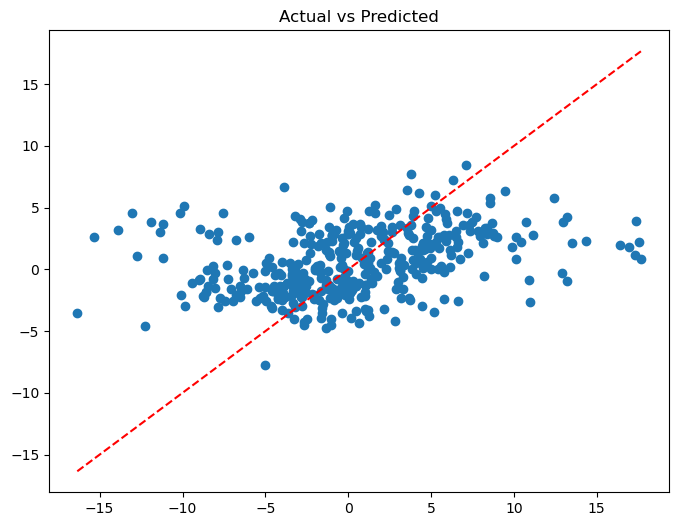



OLS Summary ZCU24.CBT:
                                 OLS Regression Results                                
Dep. Variable:          Month Returns   R-squared (uncentered):                   0.171
Model:                            OLS   Adj. R-squared (uncentered):              0.140
Method:                 Least Squares   F-statistic:                              5.575
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                    1.46e-07
Time:                        17:12:53   Log-Likelihood:                         -792.67
No. Observations:                 280   AIC:                                      1605.
Df Residuals:                     270   BIC:                                      1642.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
--------

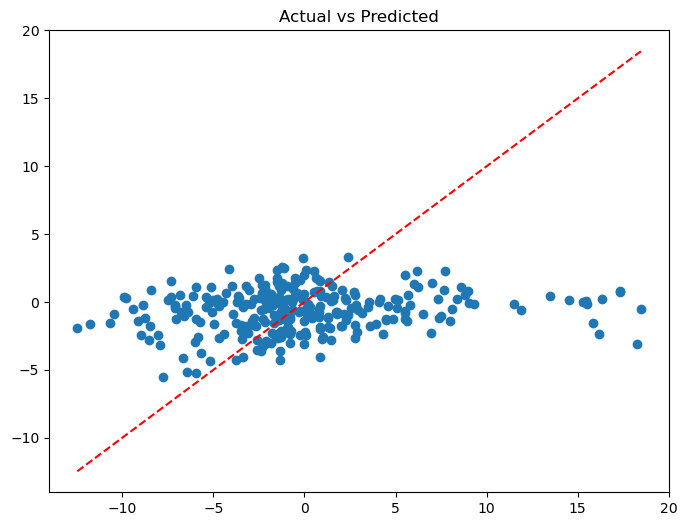



OLS Summary ZCZ24.CBT:
                                 OLS Regression Results                                
Dep. Variable:          Month Returns   R-squared (uncentered):                   0.224
Model:                            OLS   Adj. R-squared (uncentered):              0.205
Method:                 Least Squares   F-statistic:                              11.52
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                    1.96e-17
Time:                        17:12:54   Log-Likelihood:                         -1156.3
No. Observations:                 409   AIC:                                      2333.
Df Residuals:                     399   BIC:                                      2373.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
--------

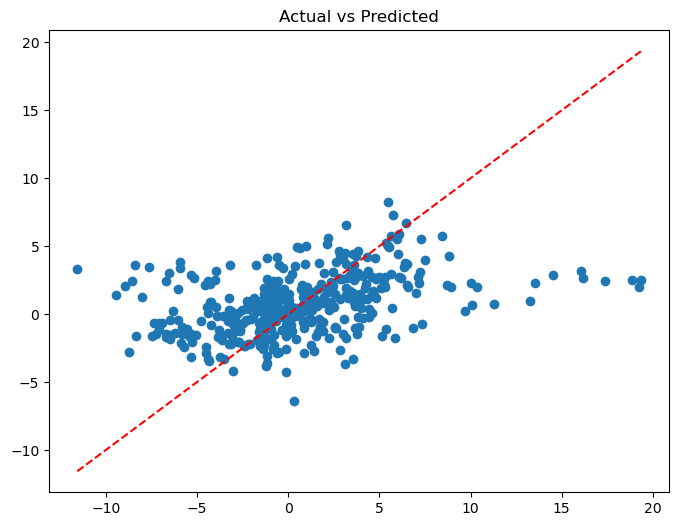



OLS Summary ZCH25.CBT:
                                 OLS Regression Results                                
Dep. Variable:          Month Returns   R-squared (uncentered):                   0.337
Model:                            OLS   Adj. R-squared (uncentered):              0.292
Method:                 Least Squares   F-statistic:                              7.486
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                    1.46e-09
Time:                        17:12:54   Log-Likelihood:                         -389.64
No. Observations:                 157   AIC:                                      799.3
Df Residuals:                     147   BIC:                                      829.8
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
--------

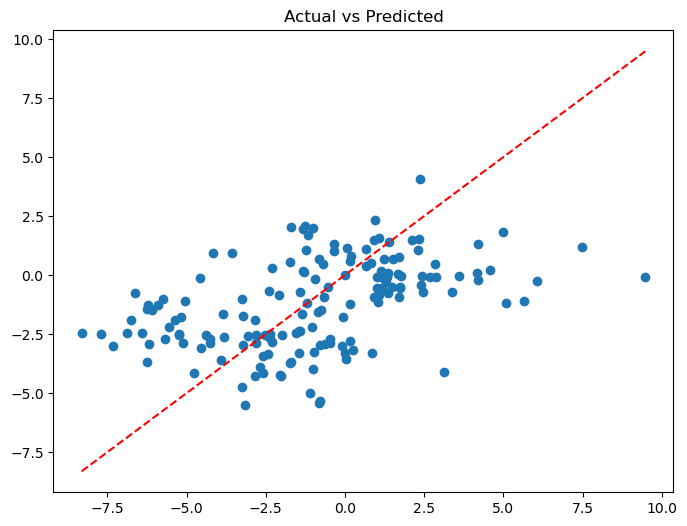



OLS Summary ZCK25.CBT:
                                 OLS Regression Results                                
Dep. Variable:          Month Returns   R-squared (uncentered):                   0.209
Model:                            OLS   Adj. R-squared (uncentered):              0.144
Method:                 Least Squares   F-statistic:                              3.216
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                     0.00105
Time:                        17:12:54   Log-Likelihood:                         -327.03
No. Observations:                 132   AIC:                                      674.1
Df Residuals:                     122   BIC:                                      702.9
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
--------

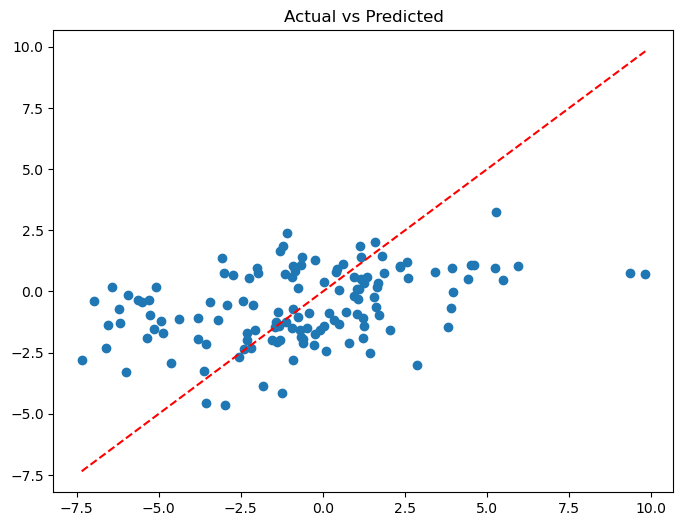



OLS Summary ZCN25.CBT:
                                 OLS Regression Results                                
Dep. Variable:          Month Returns   R-squared (uncentered):                   0.185
Model:                            OLS   Adj. R-squared (uncentered):              0.155
Method:                 Least Squares   F-statistic:                              6.031
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                    2.97e-08
Time:                        17:12:54   Log-Likelihood:                         -759.49
No. Observations:                 275   AIC:                                      1539.
Df Residuals:                     265   BIC:                                      1575.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
--------

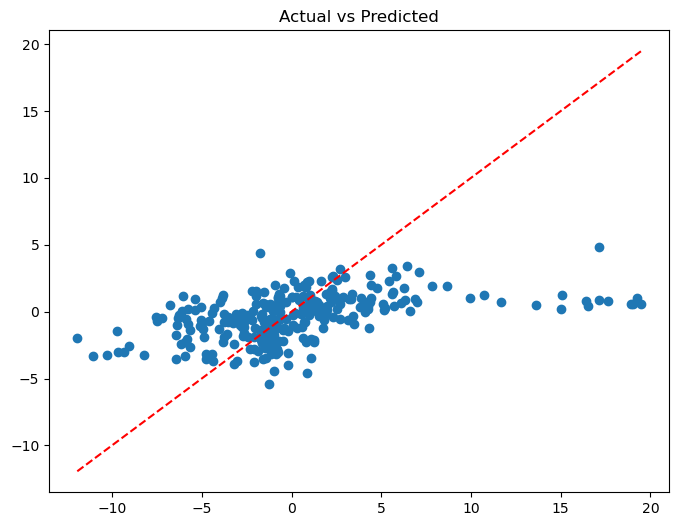



OLS Summary ZCU25.CBT:
                                 OLS Regression Results                                
Dep. Variable:          Month Returns   R-squared (uncentered):                   0.307
Model:                            OLS   Adj. R-squared (uncentered):              0.245
Method:                 Least Squares   F-statistic:                              4.956
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                    6.25e-06
Time:                        17:12:54   Log-Likelihood:                         -268.93
No. Observations:                 122   AIC:                                      557.9
Df Residuals:                     112   BIC:                                      585.9
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
--------

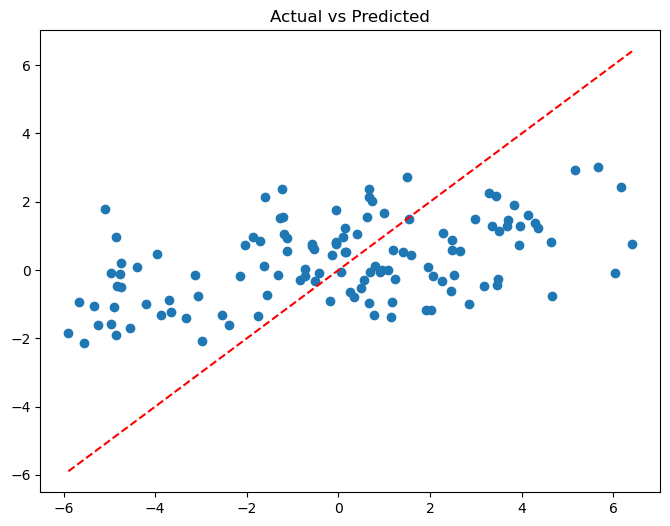



OLS Summary ZCZ25.CBT:
                                 OLS Regression Results                                
Dep. Variable:          Month Returns   R-squared (uncentered):                   0.268
Model:                            OLS   Adj. R-squared (uncentered):              0.241
Method:                 Least Squares   F-statistic:                              10.01
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                    2.68e-14
Time:                        17:12:54   Log-Likelihood:                         -740.22
No. Observations:                 283   AIC:                                      1500.
Df Residuals:                     273   BIC:                                      1537.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
--------

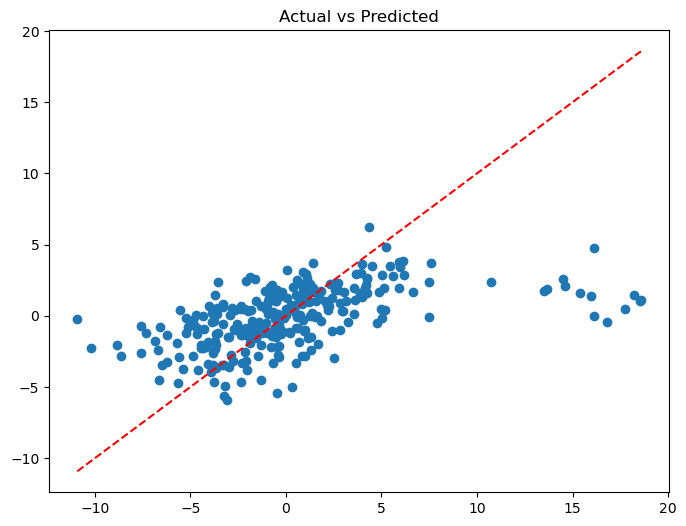



OLS Summary ZCH26.CBT:
                                 OLS Regression Results                                
Dep. Variable:          Month Returns   R-squared (uncentered):                   0.674
Model:                            OLS   Adj. R-squared (uncentered):              0.519
Method:                 Least Squares   F-statistic:                              4.340
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                     0.00223
Time:                        17:12:55   Log-Likelihood:                         -46.334
No. Observations:                  31   AIC:                                      112.7
Df Residuals:                      21   BIC:                                      127.0
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
--------

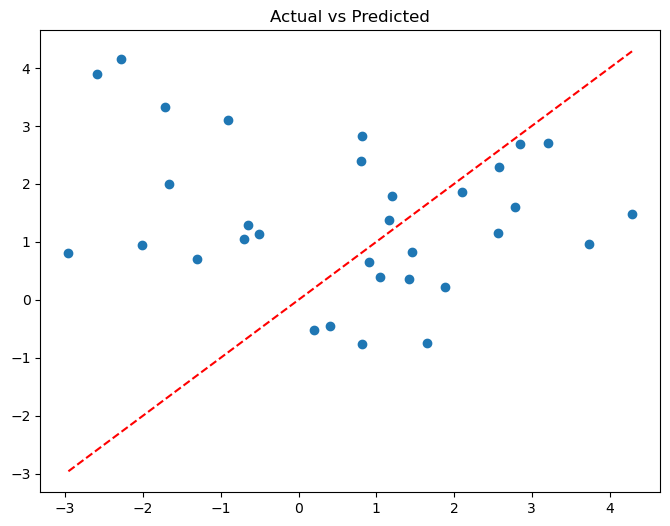



OLS Summary ZCK26.CBT:
                                 OLS Regression Results                                
Dep. Variable:          Month Returns   R-squared (uncentered):                   0.617
Model:                            OLS   Adj. R-squared (uncentered):              0.435
Method:                 Least Squares   F-statistic:                              3.388
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                     0.00887
Time:                        17:12:55   Log-Likelihood:                         -51.039
No. Observations:                  31   AIC:                                      122.1
Df Residuals:                      21   BIC:                                      136.4
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
--------

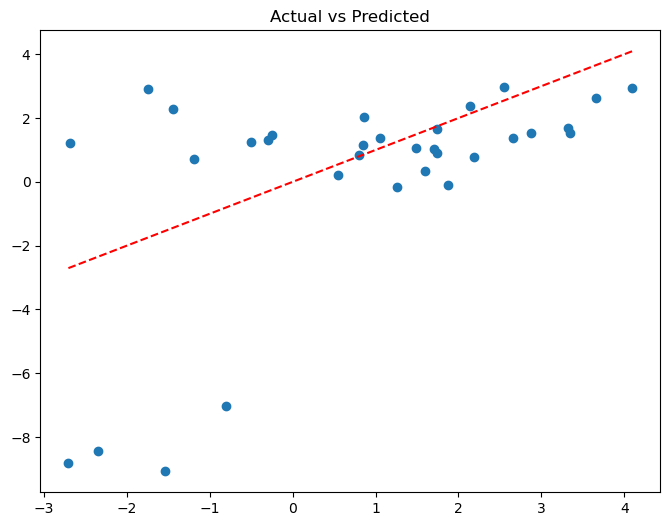



OLS Summary ZCN26.CBT:
                                 OLS Regression Results                                
Dep. Variable:          Month Returns   R-squared (uncentered):                   0.524
Model:                            OLS   Adj. R-squared (uncentered):              0.482
Method:                 Least Squares   F-statistic:                              12.46
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                    2.35e-14
Time:                        17:12:55   Log-Likelihood:                         -242.05
No. Observations:                 123   AIC:                                      504.1
Df Residuals:                     113   BIC:                                      532.2
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
--------

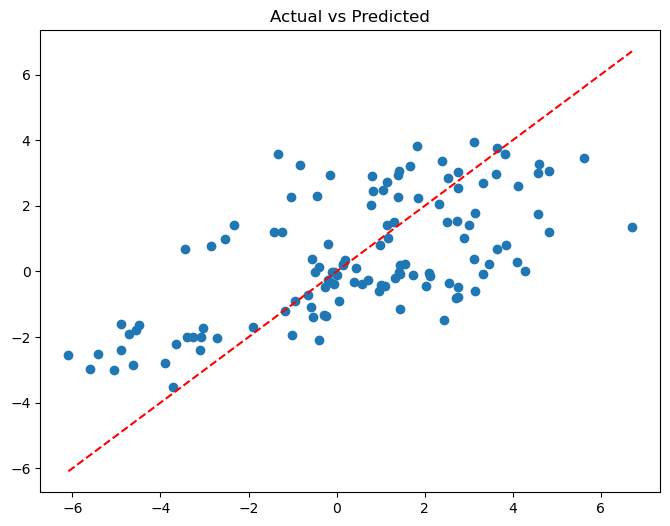



OLS Summary ZCU26.CBT:
                                 OLS Regression Results                                
Dep. Variable:          Month Returns   R-squared (uncentered):                   0.572
Model:                            OLS   Adj. R-squared (uncentered):              0.369
Method:                 Least Squares   F-statistic:                              2.812
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                      0.0220
Time:                        17:12:55   Log-Likelihood:                         -47.799
No. Observations:                  31   AIC:                                      115.6
Df Residuals:                      21   BIC:                                      129.9
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
--------

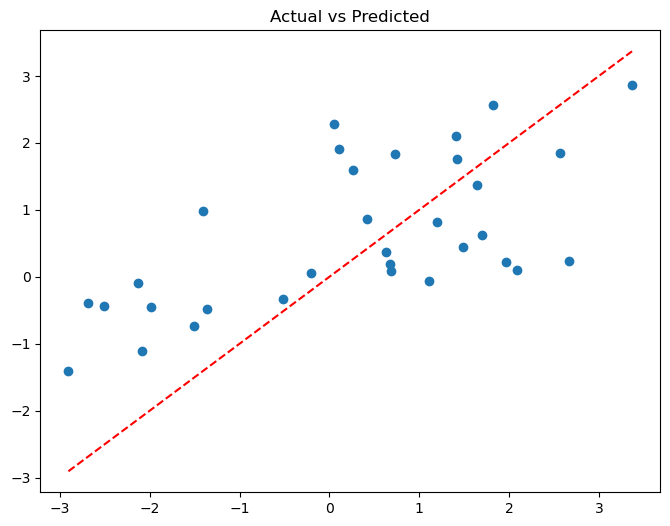



OLS Summary ZCZ26.CBT:
                                 OLS Regression Results                                
Dep. Variable:          Month Returns   R-squared (uncentered):                   0.544
Model:                            OLS   Adj. R-squared (uncentered):              0.513
Method:                 Least Squares   F-statistic:                              17.56
Date:                Sat, 15 Jun 2024   Prob (F-statistic):                    1.03e-20
Time:                        17:12:55   Log-Likelihood:                         -325.19
No. Observations:                 157   AIC:                                      670.4
Df Residuals:                     147   BIC:                                      701.0
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
--------

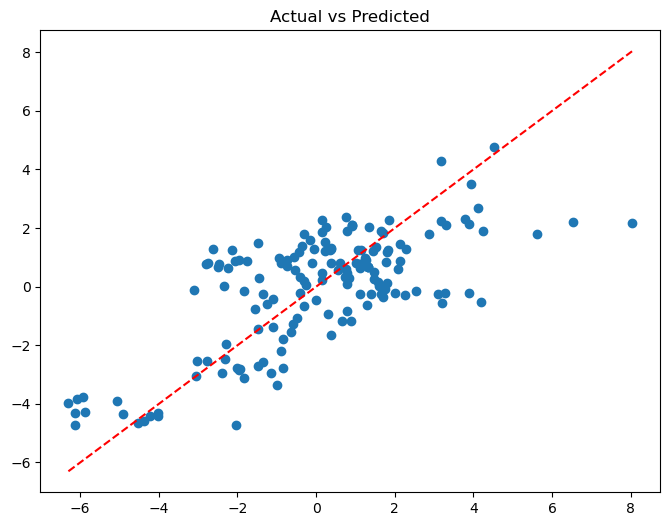



OLS Summary ZCN27.CBT:


ValueError: resids must contain at least 2 elements

In [77]:
#Inputs for OLS 
merged_df = []
for name, df in dfs_dct.items():
    print(f'OLS Summary {name}:')
    ols(df)
    print('\n')

In [ ]:
#Objective function for grid search in Random Forest
#optuna intelligently grid searches across params in params{}
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    rf_model = RandomForestRegressor(**params, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [ ]:
# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

NameError: name 'y_test' is not defined

<Figure size 800x600 with 0 Axes>

In [ ]:
'''
# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
rf_best = RandomForestRegressor(**best_params, random_state=42)
rf_best.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_best.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error(MSE): {mse:.2f}")
'''

[I 2024-06-06 13:27:09,130] A new study created in memory with name: no-name-0ad7ae0d-c1e2-4500-920e-b0d73c57397d
[I 2024-06-06 13:27:09,377] Trial 0 finished with value: 0.24402955758035655 and parameters: {'n_estimators': 275, 'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 0 with value: 0.24402955758035655.
[I 2024-06-06 13:27:09,726] Trial 1 finished with value: 0.2460772070541984 and parameters: {'n_estimators': 386, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.24402955758035655.
[I 2024-06-06 13:27:10,512] Trial 2 finished with value: 0.24472311933999805 and parameters: {'n_estimators': 879, 'max_depth': 27, 'min_samples_split': 11, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.24402955758035655.
[I 2024-06-06 13:27:10,710] Trial 3 finished with value: 0.2860878133929305 and parameters: {'n_estimators': 189, 'max_depth':

Best Hyperparameters: {'n_estimators': 237, 'max_depth': 16, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'log2'}
Mean Absolute Error (MAE): 0.41
Root Mean Squared Error (RMSE): 0.49
Mean Squared Error(MSE): 0.24


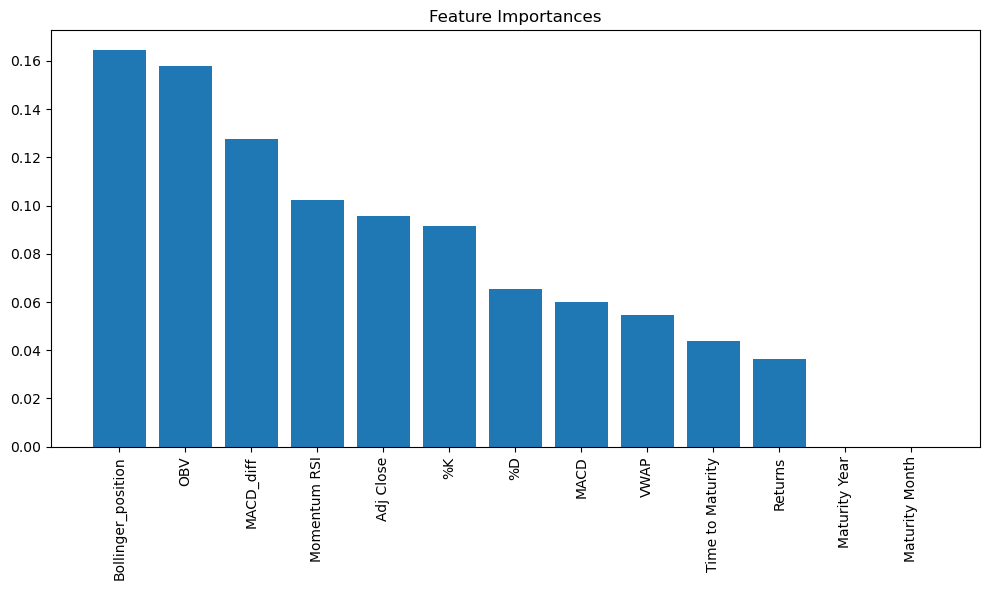

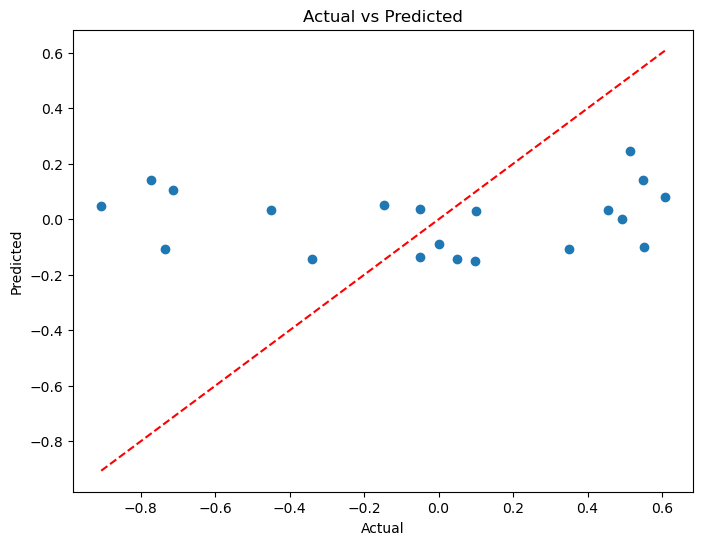

In [ ]:
# Visualization: Feature Importance
feature_importances = rf_best.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()